
# Forecasting Model for CitiBike Stations
Build models (one for each station) to predict net flow at the station for a given hour.

Use these hourly "net flow" predictions to forecast a station's bike stock.

## Abstract

Bikes accumulate or deplete quickly at certain popular locations. Companies, such as CitiBike, spend lots of effort and money to manage bike stock at each station to ensure availability to riders throughout the day. Re-balancing is currently monitored and orchestrated by human based on conversation with citiBike frontline operators.

## What should the intelligent solution be able to do?
We want the solution to be able to do the following:

- learn without explicit human instruction and intervention
- continuous improvement over time
- capture and adjust to complex and changing system dynamics

## Import Libraries

In [1]:
!pip install geopandas

In [2]:
import os
import sklearn
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import matplotlib.style as style
from urllib.request import urlretrieve
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor

style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
os.chdir("/content/drive/MyDrive/Bike Rebalancing")

## Import outside datasets: Weather and Station Info

Weather dataset from [MeteoStat Website](https://meteostat.net/en/place/US-KT2M?t=2019-07-25/2019-07-31) 

In [5]:

weather = pd.read_csv('Weather.csv')
weather['time_local'] = pd.to_datetime(weather['time_local'])
weather['date'] = [i.date() for i in weather["time_local"]]
weather['hour'] = [i.hour for i in weather["time_local"]]
weather['hour'] = pd.to_numeric(weather['hour'], downcast='float')
weather.drop(columns=['time', 'time_local','tsun','wpgt','snow'], inplace=True)
weather['date'] = pd.to_datetime(weather['date'])
weather.head()

,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,date,hour
0,0.0,-8.2,54,0.0,40,18,1025.4,3,2019-03-01,0.0
1,0.0,-6.6,61,0.0,60,17,1025.7,4,2019-03-01,1.0
2,0.0,-6.6,61,0.0,40,13,1026.2,4,2019-03-01,2.0
3,0.0,-6.6,61,0.0,60,9,1026.6,4,2019-03-01,3.0
4,0.0,-6.6,61,0.0,50,15,1026.0,4,2019-03-01,4.0


## Set Dates
The goal is to predict net flows in July 2020. Therefore, we will use data from April 2019-July 2019 and from April 2020-June 2020 as our training set. The data from 2019 will capture any seasonal trends, while the 2020 data will capture recent trends.

We will also add March 2020 as a "buffer" between the 2019 and 2020 sets. How is this a buffer? We'll include March 2020 to help ease the creation of accurate autoregressive features, but will remove March 2020 when training the model. Doing so will ensure that the autoregressive features for April 2020 records are accurate (based on March values), and not distorted by July 2019 values.

In [6]:
dates19 = pd.date_range(start=pd.datetime(2019, 3, 1), end=pd.datetime(2019, 7, 31),
                        freq='D')

dates20 = pd.date_range(start=pd.datetime(2020, 3, 1), end=pd.datetime(2020, 7, 31),
                        freq='D')                       

D = dates19.append(dates20)
dates = [x.date() for x in D]


years = ['2019','2020']
months = ['03', '04', '05', '06', '07']

In [7]:

BIKE = pd.DataFrame()
bikes = []

""""
Note that for some months, the column names were in upper case. Thus I converted
them to lower case, so that monthly datasets can be easily appended. 
"""

standard_cols = ['tripduration', 'starttime', 'stoptime', 'start station id',
                     'start station name','start station latitude', 'start station longitude',
                     'end station id', 'end station name', 'end station latitude',
                     'end station longitude', 'bikeid', 'usertype', 'birth year', 'gender']     


for y in years:
    for m in months:
        if (y=="2019" and m == "03"):
            continue
        elif (y == "2020" and (m == "06" or m == "07")):
            df = pd.read_csv(y+m+"-citibike-tripdata.csv.zip")
        else:
            df = pd.read_csv("https://s3.amazonaws.com/tripdata/"+y+m+"-citibike-tripdata.csv.zip")
        for c in range(len(df.columns.values)):
            df = df.rename(columns={df.columns.values[c]:standard_cols[c]})
        bikes.append(df)

for df in bikes:
    BIKE = BIKE.append(df)
BIKE.shape

(15224281, 15)

## Designate Stations to Model

Considering Small Subset Of Stations for this Project

519: Pershing Square North

392: Jay St & Tech Pl

426: West St & Chambers St

497: E 17 St & Broadway

3164: Columbus Ave & W 72 St

281: Grand Army Plaza & Central Park S

3443: W 52 St & 6 Ave

304: Broadway & Battery Pl

3375: 3 Ave & E 72 St

3283: W 89 St & Columbus Ave


In [8]:
stats = BIKE[['start station id', 'start station name']].drop_duplicates() \
                                                        .reset_index(drop=True) 

IDs_smaller = [519, 392, 426, 497, 3164, 281, 3443, 304, 3375, 3283]

## Map of these Stations

In [9]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'

try:
    urlretrieve(url, "file.zip")
    if os.path.isfile("geo_export_04b91470-87bd-4f6c-bae8-406f62b9cb9a.shp"):
        print("Files exist. Pass.")
    else:
        !unzip file.zip
except:
    pass

# nyc_map = gpd.GeoDataFrame.from_file("geo_export_6989d0d6-a632-4cc8-a434-b27594f0ff2a.shp")

Archive:  file.zip
  inflating: geo_export_1f819c5f-86ab-4007-916d-b233f2f59246.dbf  
  inflating: geo_export_1f819c5f-86ab-4007-916d-b233f2f59246.shp  
  inflating: geo_export_1f819c5f-86ab-4007-916d-b233f2f59246.shx  
  inflating: geo_export_1f819c5f-86ab-4007-916d-b233f2f59246.prj  


In [10]:
nyc_map = gpd.read_file("Borough Boundaries/geo_export_6fa91cbc-3b2c-41c4-a3ad-76291792a32a.shp")
# nyc_map = gpd.GeoDataFrame.from_file("geo_export_6fa91cbc-3b2c-41c4-a3ad-76291792a32a.shp")

In [11]:
nyc_map

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5.0,Staten Island,1.623677e+09,326060.058079,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2.0,Bronx,1.187231e+09,464720.015850,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,3.0,Brooklyn,1.934095e+09,729595.348997,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,4.0,Queens,3.042318e+09,903938.441308,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
4,1.0,Manhattan,6.366055e+08,359935.015632,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."


In [12]:
uni_dep_stations = BIKE[['start station id', 'start station name', 
                         'start station latitude', 'start station longitude']].drop_duplicates()

uni_arv_stations = BIKE[['end station id', 'end station name', 
                         'end station latitude', 'end station longitude']].drop_duplicates()

# Create a dataset with all unique station id, name, and lat/lon
uni_dep_stations.columns = ["id", "name", "lat", "lon"]
uni_arv_stations.columns = ["id", "name", "lat", "lon"]
uni_station = pd.concat([uni_dep_stations, uni_arv_stations], axis = 0).drop_duplicates(subset=["id"])
uni_station.head()

Locations = uni_station[uni_station['id'].isin(IDs_smaller)].reset_index(drop=True)

In [13]:
Locations

,id,name,lat,lon
0,519.0,Pershing Square North,40.751873,-73.977706
1,281.0,Grand Army Plaza & Central Park S,40.764397,-73.973715
2,497.0,E 17 St & Broadway,40.737050,-73.990093
3,304.0,Broadway & Battery Pl,40.704633,-74.013617
4,3443.0,W 52 St & 6 Ave,40.761330,-73.979820
5,3164.0,Columbus Ave & W 72 St,40.777057,-73.978985
6,3283.0,W 89 St & Columbus Ave,40.788221,-73.970416
7,426.0,West St & Chambers St,40.717548,-74.013221
8,3375.0,3 Ave & E 72 St,40.769943,-73.960607
9,392.0,Jay St & Tech Pl,40.695065,-73.987167


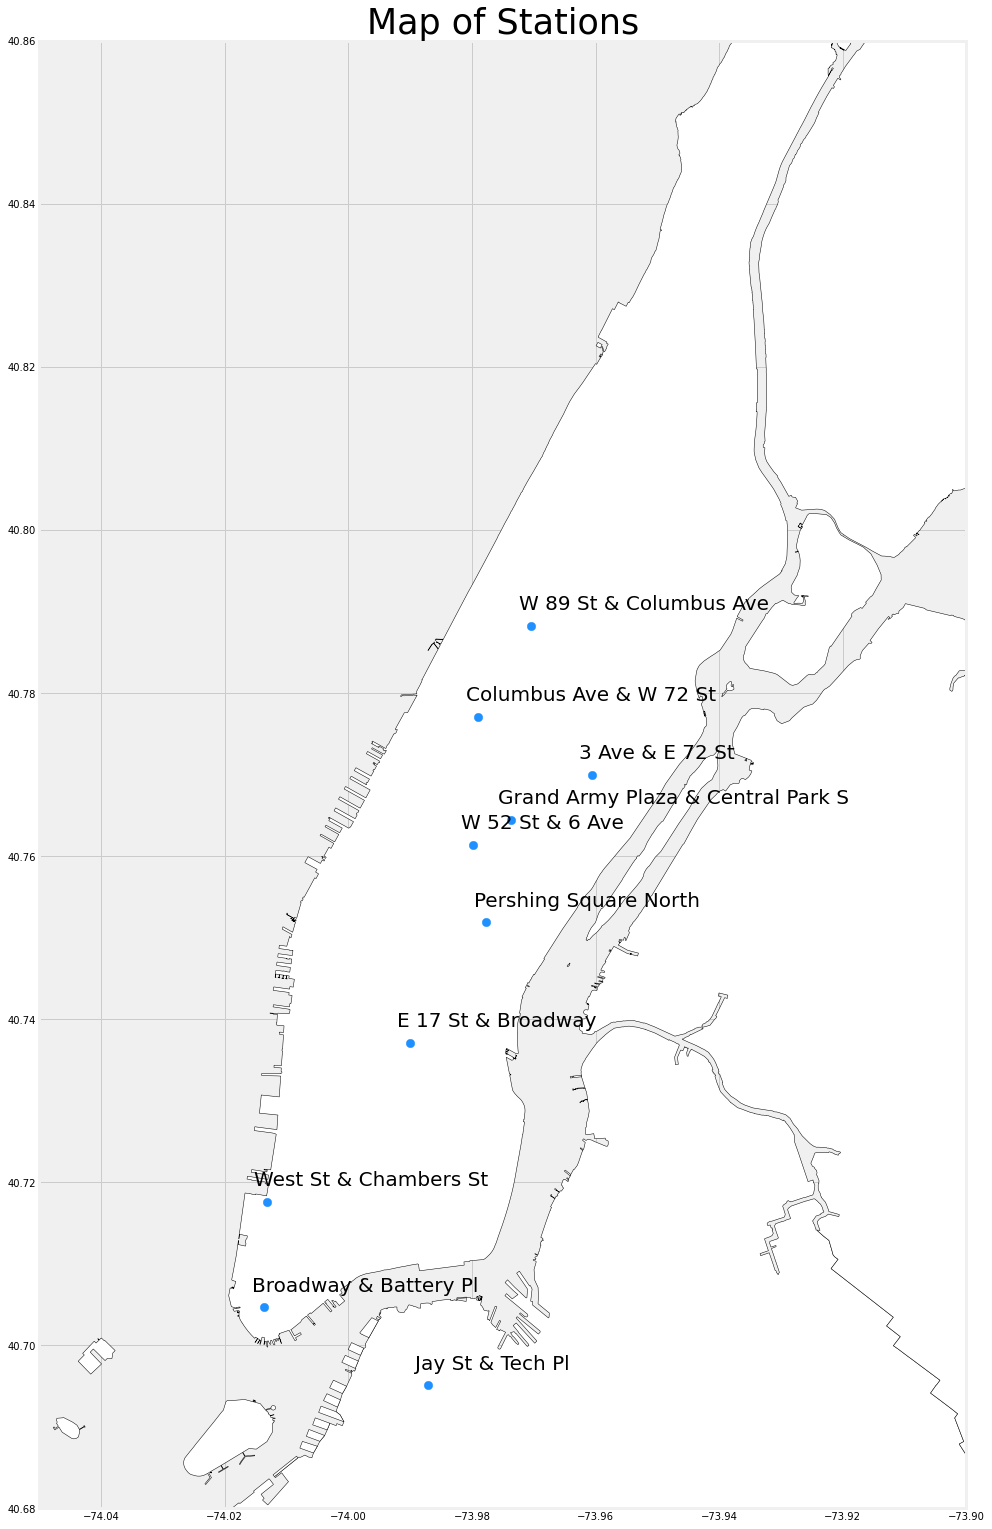

In [14]:

ys = list(Locations['lat'])
xs = list(Locations['lon'])

f, ax = plt.subplots(figsize = (18, 27));
nyc_map.plot(ax = ax, color = "white", edgecolor = 'black');


plt.xlim((-74.05, -73.9));
plt.ylim((40.68, 40.86));
plt.scatter(xs, ys, color='dodgerblue', s=70);

for r in range(len(Locations)):
    lat = Locations.loc[r, 'lat']
    long = Locations.loc[r, 'lon']
    idx = Locations.loc[r, 'name']
    plt.annotate(idx, (long-0.002, lat+0.002), size=20)

plt.title("Map of Stations", size = 35);

## Set Up And Solution

I want to design an intelligent solution that can do the following without explicit human instructions:

- Maintain bike stocks within a certain range (0 to 50)
- Understand what the bike stock requirements are
- Decide how many bikes to move to meet the requirements 
- Determine when to move bikes

By trial and error, the solution should meet the following objectives:
- Higher success ratio: keep bike stock within a certain range (0 - 50 bikes by hour 23)
- Lower cost: move the least amount of bikes possible

### Important Functions

In [15]:
def correctDateTime(dataset):
    """
    Purpose of this function is to parse the date column within the dataset
    and separate the dates to hour and week-day of every ride
    
    ::params::
    dataset: Bike Dataset with information regarding each Bike Ride

    ::return:: modified dataset and name of the station
    """
    name = dataset[dataset['end station id']==ID].reset_index().loc[0, 'end station name']
    
    bike = dataset[(dataset['start station id'] == ID)|
            (dataset['end station id'] == ID)].reset_index(drop=True)
    
    ### Parse date-time columns 
    bike['starttime'] = pd.to_datetime(bike['starttime'], infer_datetime_format= True)
    bike['stoptime'] = pd.to_datetime(bike['stoptime'], infer_datetime_format= True)
    bike['day'] = bike['starttime'].dt.day
    bike['start_hour'] = bike['starttime'].dt.hour
    bike['end_hour'] = bike['stoptime'].dt.hour
    bike['DOW'] = bike['starttime'].dt.dayofweek
    bike['date'] = bike['starttime'].dt.date

    return bike, name

In [16]:
def HourlyCount(dataset, Departure=True):
    """
    This function counts the Hourly Arrival/Departure of Bikes at every Station

    ::params::
    dataset: Bike Dataset parsed with correct date
    
    ::return::
    A Pivot Table of Hourly Arrival/Departure and columns modified as per the use case
    """
    if Departure:
        # Departure
        filteredColumns = ['start station id', 'date','start_hour','starttime']
        column = ['date','start_hour']
        columnName = "dep_"
        pivotElement = "start station id"
    else:
        # Incoming Bikes
        filteredColumns = ['end station id', 'date','end_hour', 'stoptime']
        column = ['date', "end_hour"]
        columnName = "arv_"
        pivotElement = "end station id"

    month = pd.pivot_table(dataset[filteredColumns],
                             index = pivotElement, columns=column,
                             aggfunc = np.size, fill_value= 0).reset_index()

    month.columns = [columnName + str(day).replace(' 00:00:00','') + "_" + str(hour) for _,day,hour in month.columns]    

    return month

In [17]:
def MergeTables(Table1, Table2, multiple=False, cols=[]):
    """
    Merge Two Table and return Net Table
    
    ::params::
    Table1: First Table to be merged
    Table2: Second Table to be merged
    multiple: If needed left and right merge.
    cols : Columns on which merge is performed
    This will Happen only while merging arrival and departure tables

    ::Return::
    A merged Table
    """
    if multiple:
        merge = Table1.merge(Table2, left_on=cols[0], right_on=cols[1])
        merge = merge.rename(columns={cols[0]:'id'}).drop(cols[1], 1)
    else:
        merge = Table1.merge(Table2, on=cols)
    
    return merge

In [18]:
def BreakTimeColumn(StationActivity, dates):
    """
    Reshape data such that each row is one hour, and the columns 
    are departures, arrivals, and net flows for that hour

    ::params::
    StationActivity : Merged Table of Arrival and Departure
    dates : Range of dates within the dataset

    ::return::
    Return the dataset with all dates and times in it
    """
    for day in dates:
        for hour in range(0, 24):
            net_col = "net_" + str(day) + "_" + str(hour)
            dep_col = "dep_" + str(day) + "_" + str(hour)
            arv_col = "arv_" + str(day) + "_" + str(hour)
            try:
                StationActivity[net_col] = StationActivity[arv_col]-StationActivity[dep_col]
            except (KeyError):
                if arv_col in StationActivity.columns.values:
                    StationActivity[dep_col] = 0
                elif dep_col in StationActivity.columns.values:
                    StationActivity[arv_col] = 0
                else:
                    StationActivity[arv_col] = 0
                    StationActivity[dep_col] = 0
                StationActivity[net_col] = StationActivity[arv_col]-StationActivity[dep_col]
    StationActivity = StationActivity.set_index(StationActivity['id'])
    return StationActivity


In [19]:
def recreate_date_column(df):
    """
    Convert Columns to their datetype

    ::params::
    df: dataset with date column

    ::return::
    Return Dataset with the converted columns
    
    """
    df['date'] = pd.to_datetime(df.index.map(lambda x: x.split('_')[1]))
    df['weekday'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['hour'] = df.index.map(lambda x: int(x.split('_')[2]))
    df = df.reset_index(drop=True)
    return df

In [20]:
def PreprocessData(StationActivity, ID, columnName=""):
    """
    Preprocessing before introducing Autoregression and Modelling
    """

    col = [c for c in StationActivity.columns.values if columnName in c]
    cols = StationActivity[col].T
    cols = cols.rename(columns={ID:columnName+"s"})
    cols2 = recreate_date_column(cols)
    return cols2

In [21]:
def introduceAutoregrression(total, labels):
    """
    Introduce Autoregression Features to the dataset
    This is done by comparing Hourly Change, followed by Daily, then weekly and finally Monthly

    ::params::
    total: dataset
    labels: columns on which Autoregression is induced

    ::return::
    Dataset with Autoregression values
    """
    time_steps = list(np.arange(1,25))
    time_steps.extend([48, 72, 96, 120, 144, 168, 336, 504])    
    for label in labels:
        #For each time step...
        for t in time_steps:
            lagged_starts = np.empty(t)
            lagged_starts[:] = np.nan
            lagged_starts = list(lagged_starts)
            lagged_starts.extend(list(total[label][:-t]))
            total[label+' t-'+str(t)] = lagged_starts
        
        # Complicated cleaning for t-336 and t-504
        total[label+' t-336'] = np.where((total[label+' t-336'].isnull())&(-total[label+' t-168'].isnull()),
                              total[label+' t-168'], total[label+' t-336'])
        total[label+' t-504'] = np.where((total[label+' t-504'].isnull())&(-total[label+' t-336'].isnull()),
                              total[label+' t-336'], total[label+' t-504'])
    
        total[label+'_12h'] = total.index.map(lambda x: total.loc[x, label+' t-1': label+' t-12'].sum())
        total[label+'_24h'] = total.index.map(lambda x: total.loc[x, label+' t-1': label+' t-24'].sum())
    
        total['hour_average_'+label+'_past_week'] = (total[label+' t-24']+total[label+' t-48']+total[label+' t-72']+ 
                                   total[label+' t-96']+total[label+' t-120']+total[label+' t-144']+
                                   total[label+' t-168'])/7
    
        total['hour_average_'+label+'_weekday_past3'] = (total[label+' t-168']+total[label+' t-336']+
                                                     total[label+' t-504'])/3
        # To avoid overfitting
        for ts in time_steps:
            if ts < 3:
                pass
            else:
                total = total.drop(label+' t-'+str(ts), 1)

    return total

In [22]:
def TrainTestSplit(dataset, dates):
    """
    Split the dataset to Training and Testing Regions
    """

    # Removing March Month
    modifiedDataset = dataset[dataset['month'] != 3].reset_index(drop=True)
    dates = [x for x in dates if x.month !=3]
    
    # Predict Net Flow at a particular hour 
    cutoff = 5112
    # Point where July 2020 Data starts
    start = 168 
    # Fisrt Full Dataset witihout any Nulls 
    # for first 168 elements nulls are created due to multiple merge and removal of March month
    
    X = modifiedDataset.drop(['date','nets', 'deps', 'arvs'], 1)
    y = modifiedDataset['nets']

    TrainX = X[start:cutoff]
    TestX = X[cutoff:]
    TrainY = y[start:cutoff]
    TestY = y[cutoff:]
    return TrainX, TestX, TrainY, TestY, modifiedDataset, X, y

In [23]:
def Modeling(TrainX, TextX, TrainY, TestY):
    RF = RandomForestRegressor(random_state=12, min_samples_leaf=5)
    RF.fit(TrainX, TrainY)
    preds = RF.predict(TestX)     
    TestScore = round(RF.score(TestX, TestY),3)
    TrainScore = round(RF.score(TrainX, TrainY), 3)
    return preds, RF, TestScore, TrainScore

## Bind Code

Steps:

1. Find all Arrival and departing Bikes at each station at each hour
2. Add Autoregressive features to the dataset
3. Model Using **Random Forest Regressor**
4. Track R^2 results for both Training and Testing set
5. Visualize Outputs for Daily, hourly, Daily, Weekly and Monthly
6. Repeat for all Stations

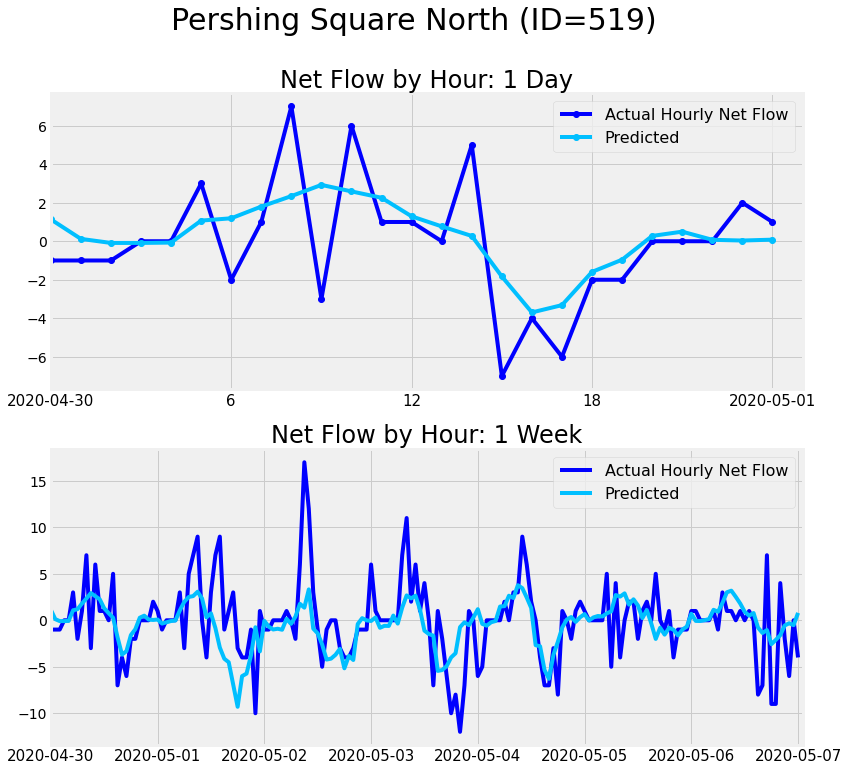

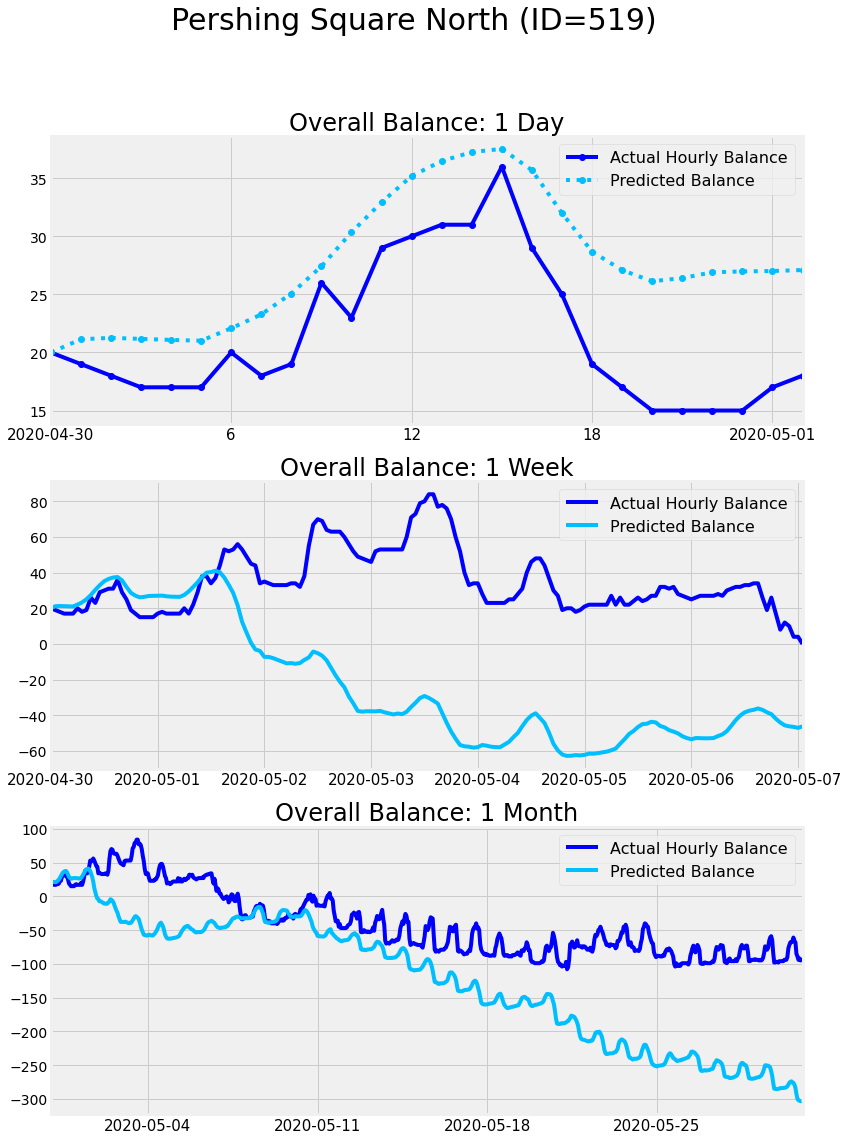

Finished Training for Station ID: 519


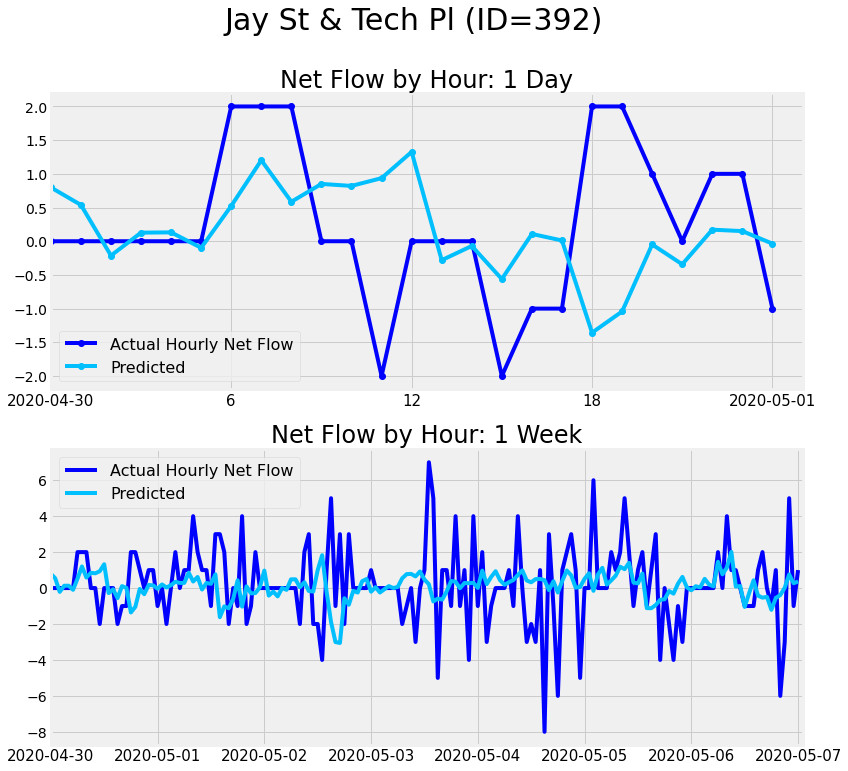

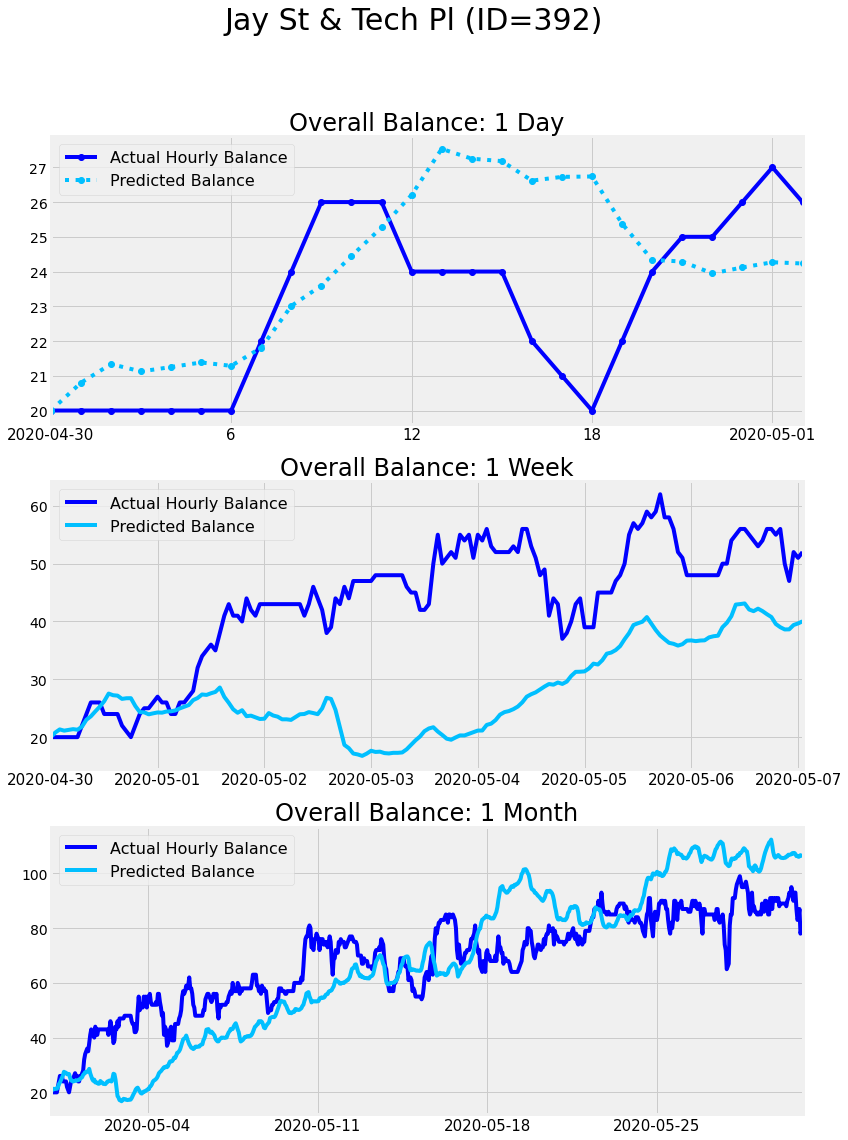

Finished Training for Station ID: 392


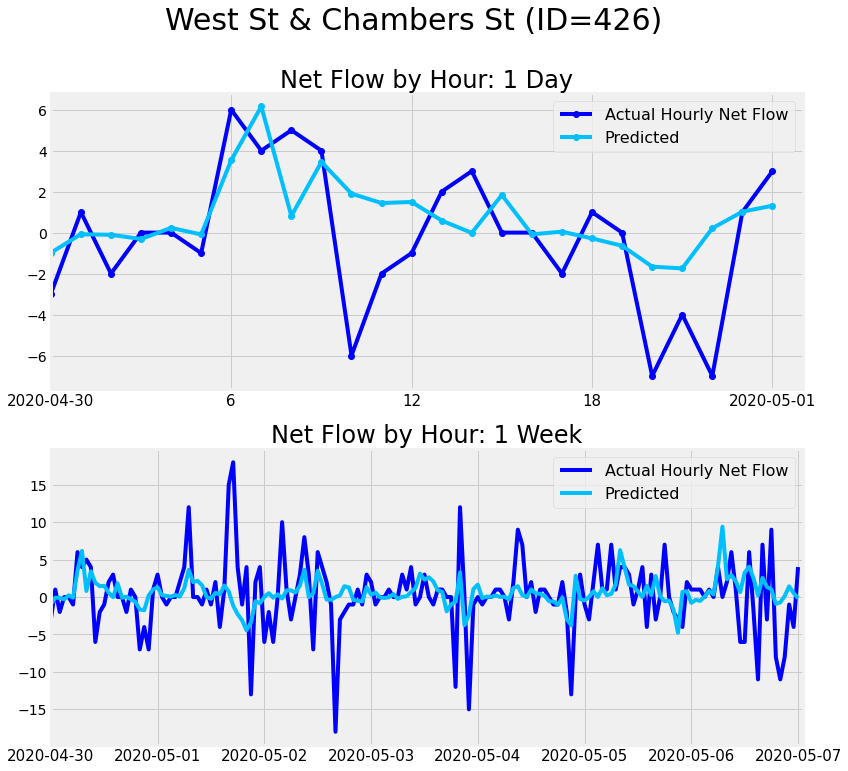

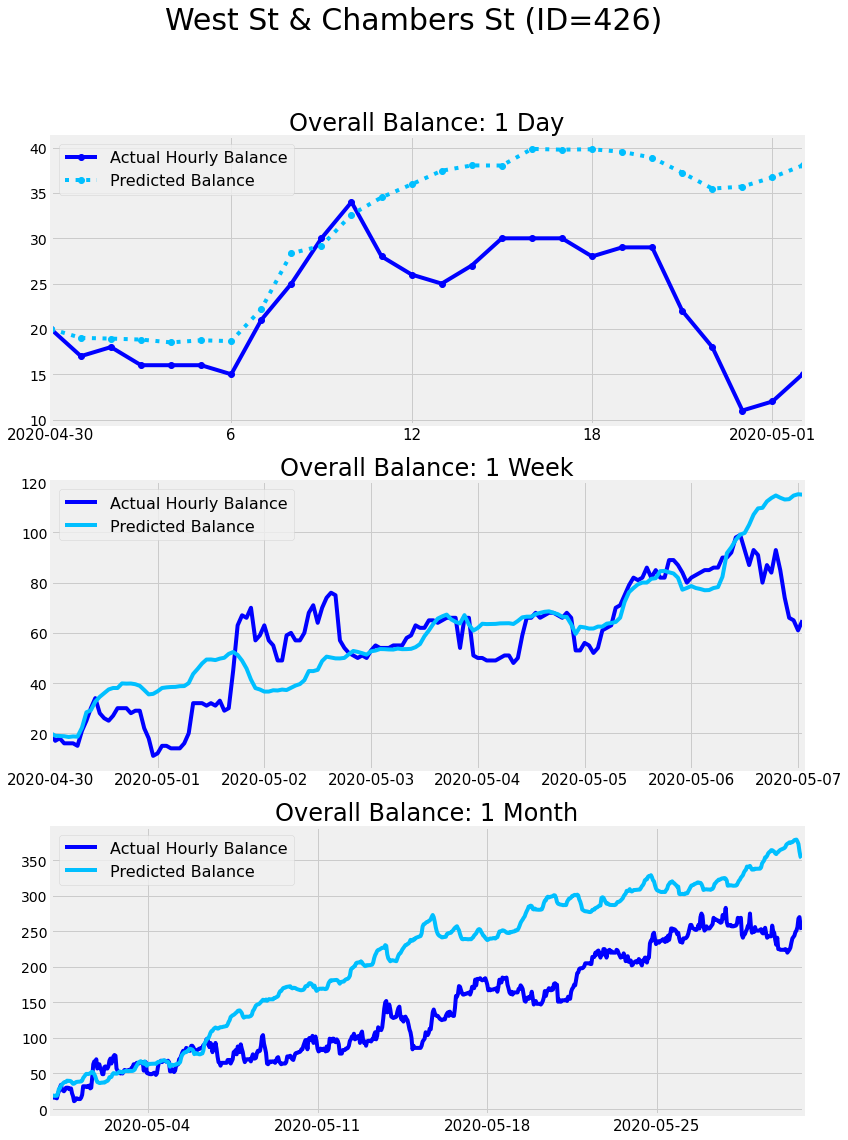

Finished Training for Station ID: 426


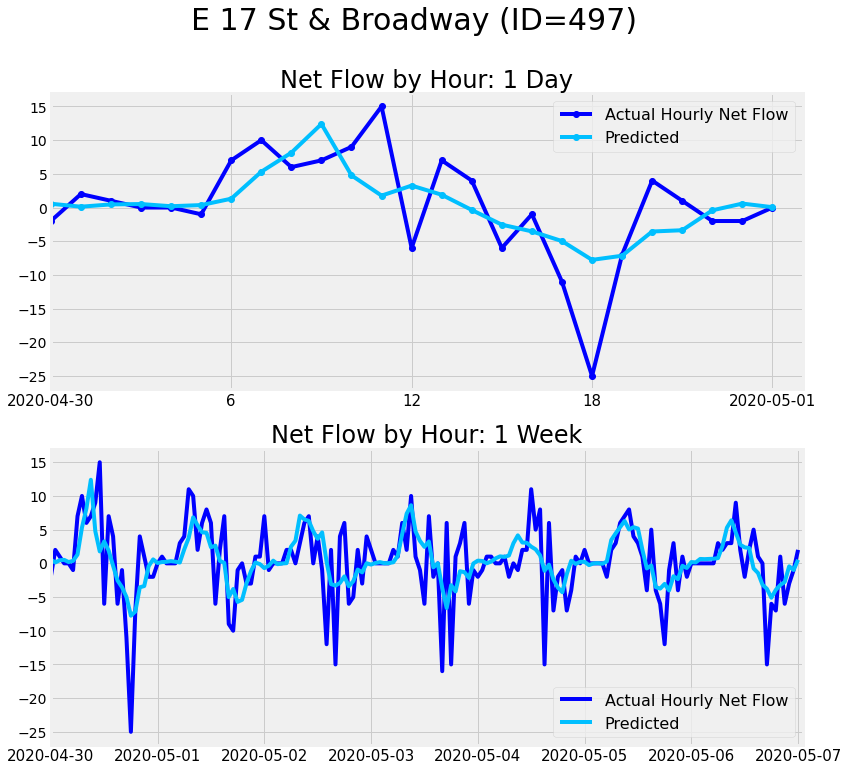

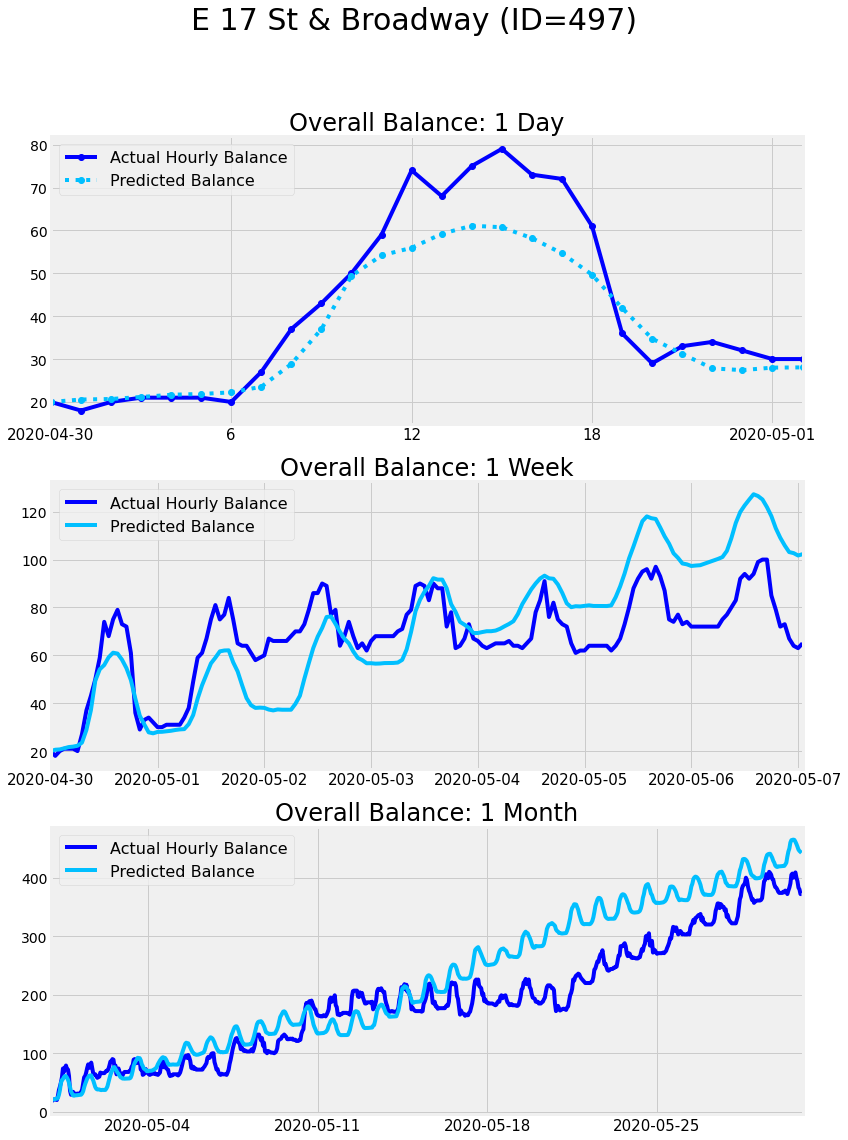

Finished Training for Station ID: 497


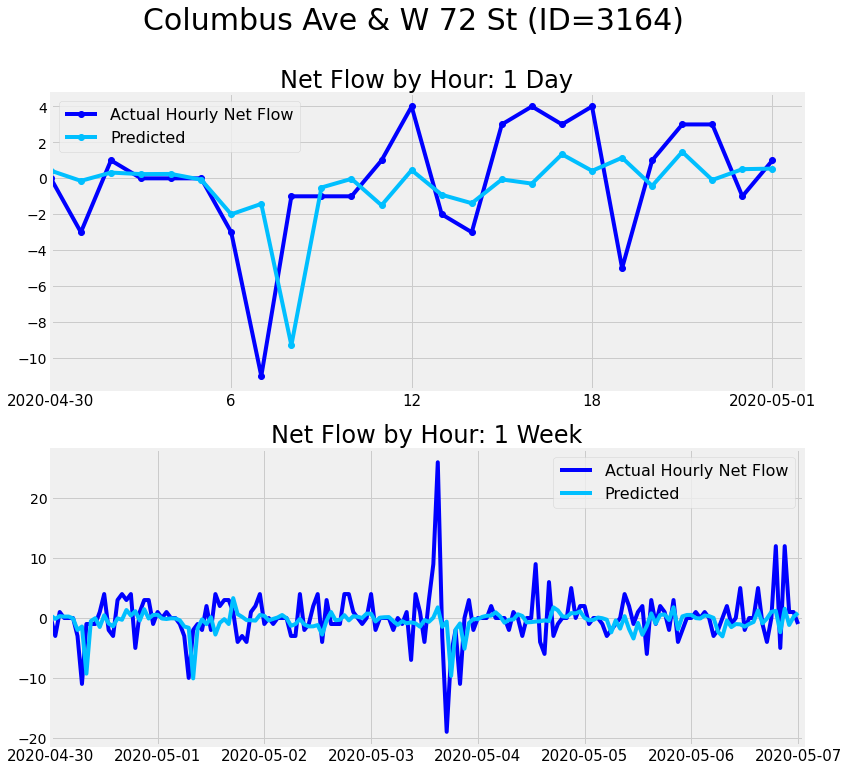

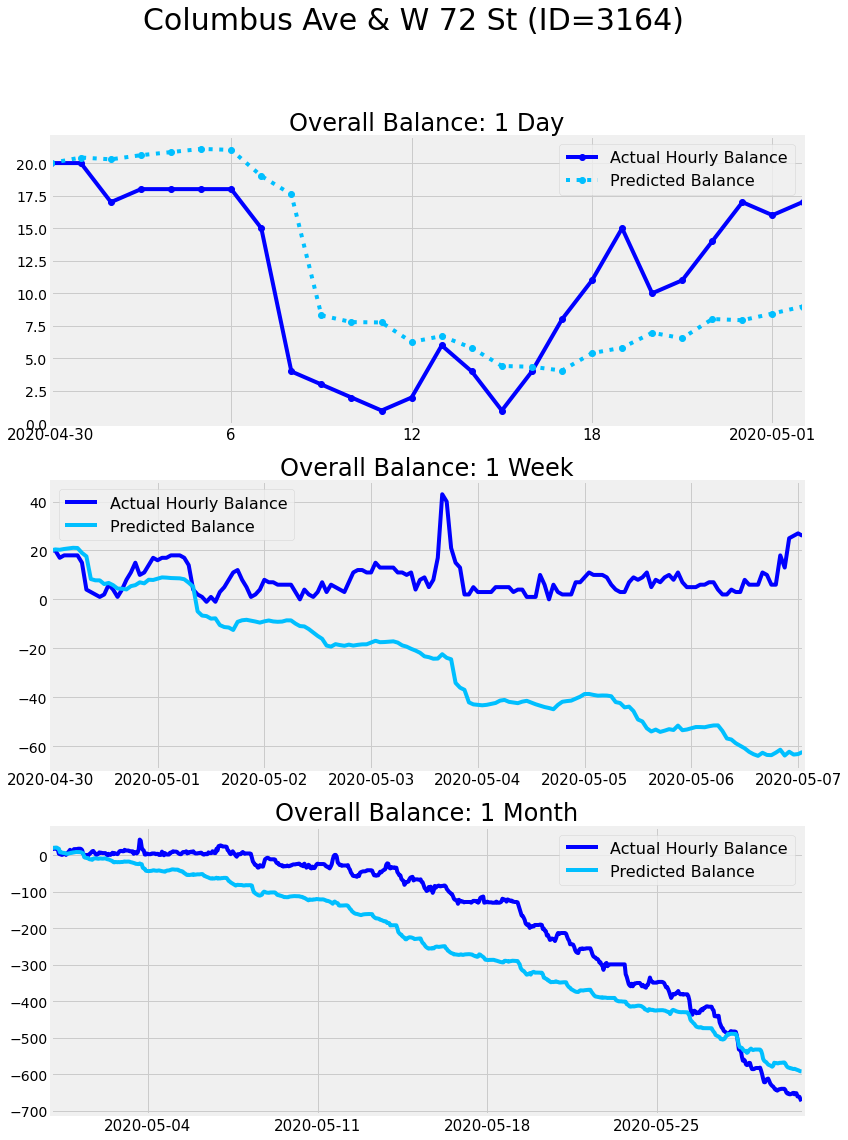

Finished Training for Station ID: 3164


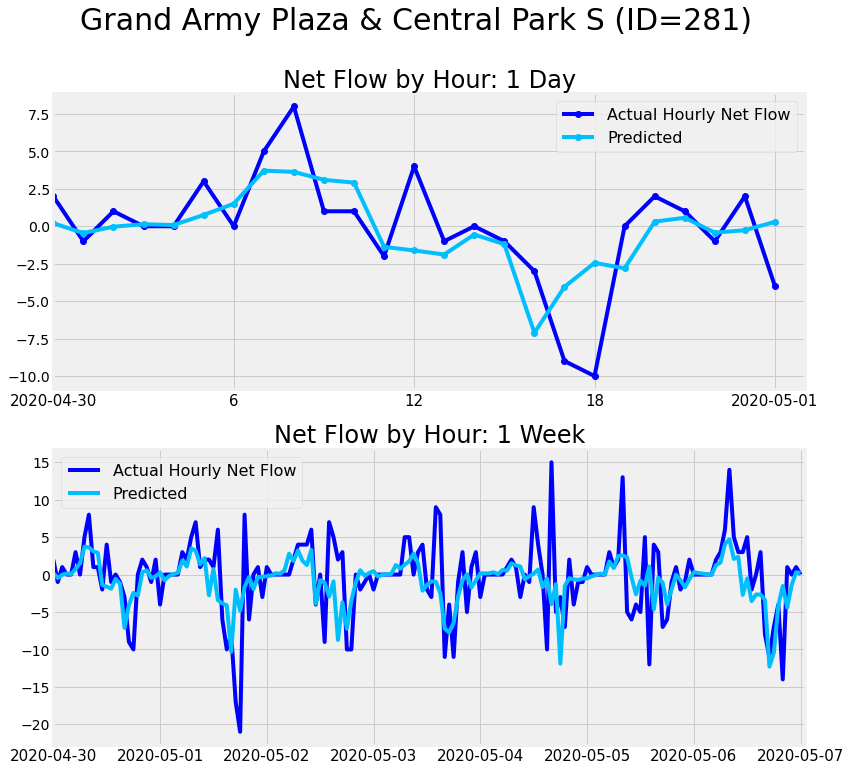

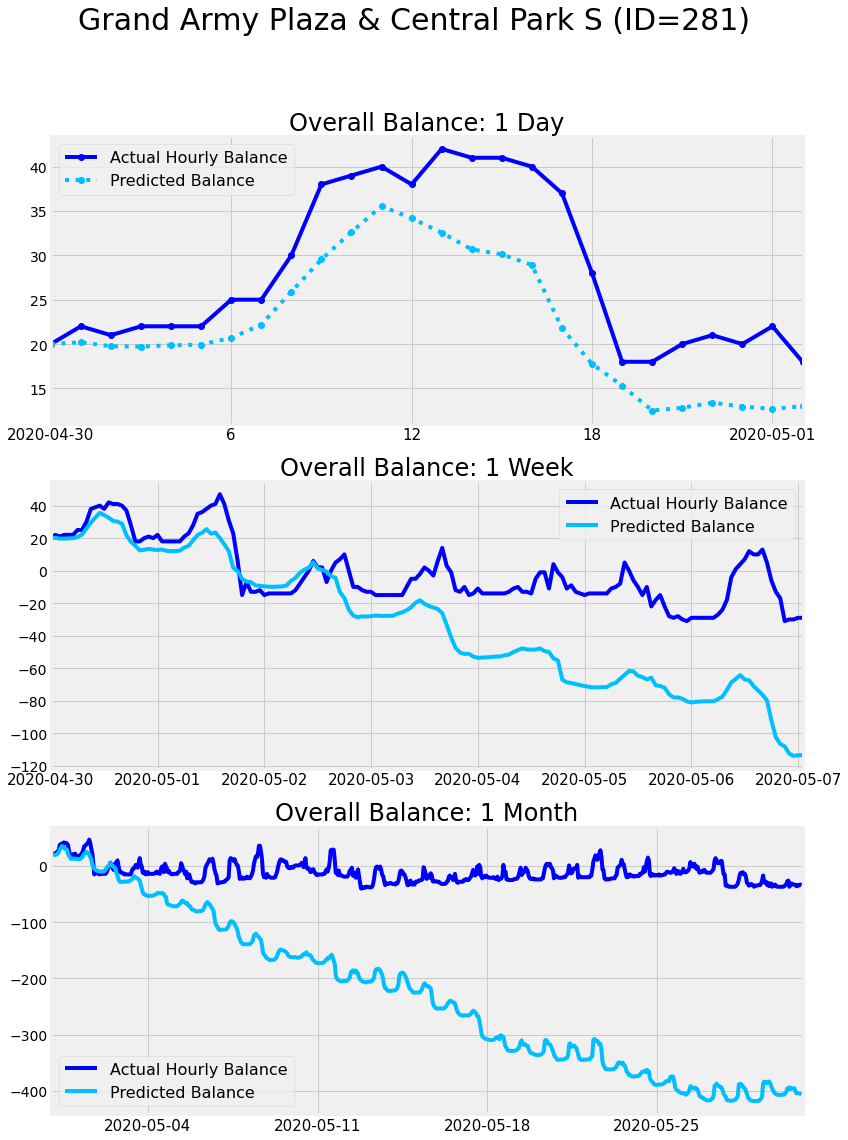

Finished Training for Station ID: 281


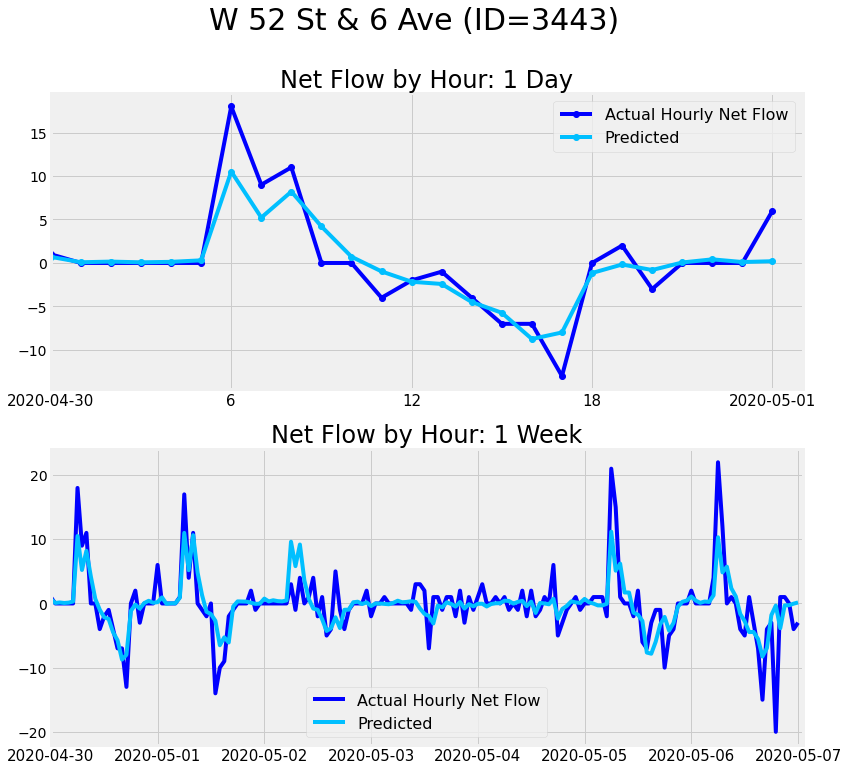

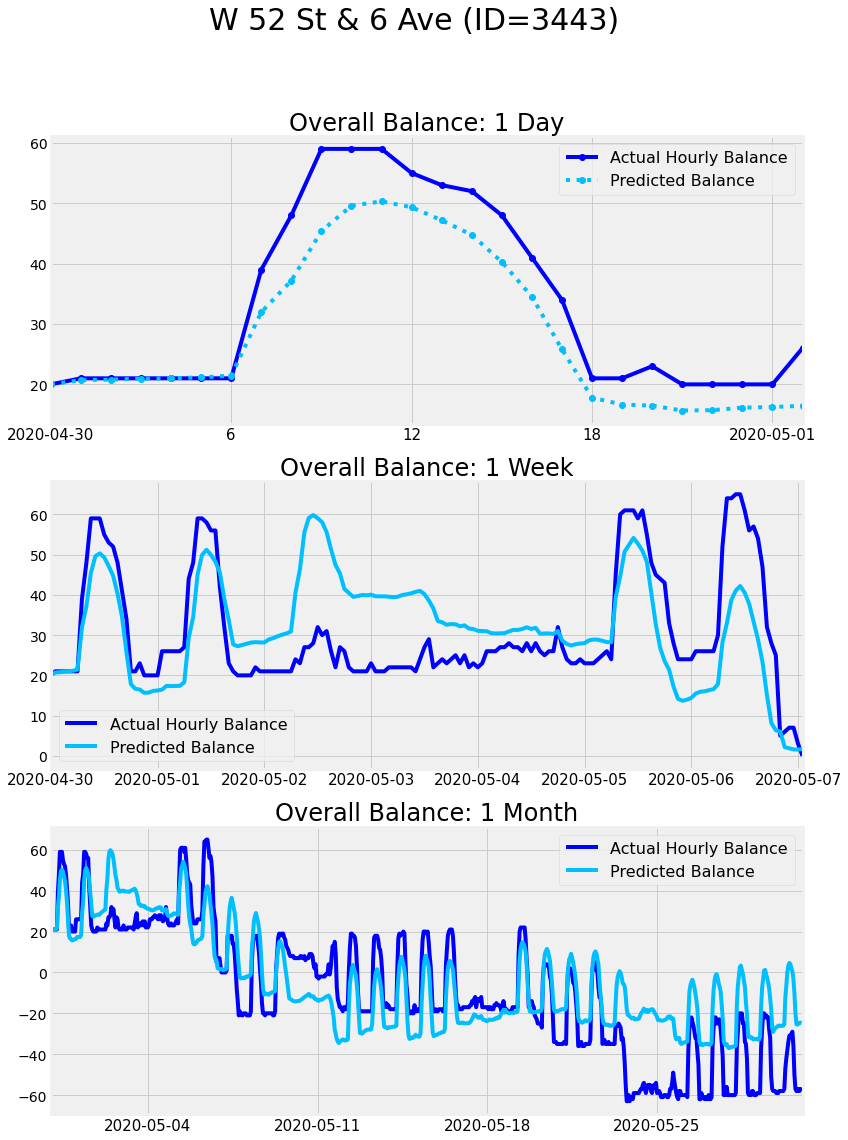

Finished Training for Station ID: 3443


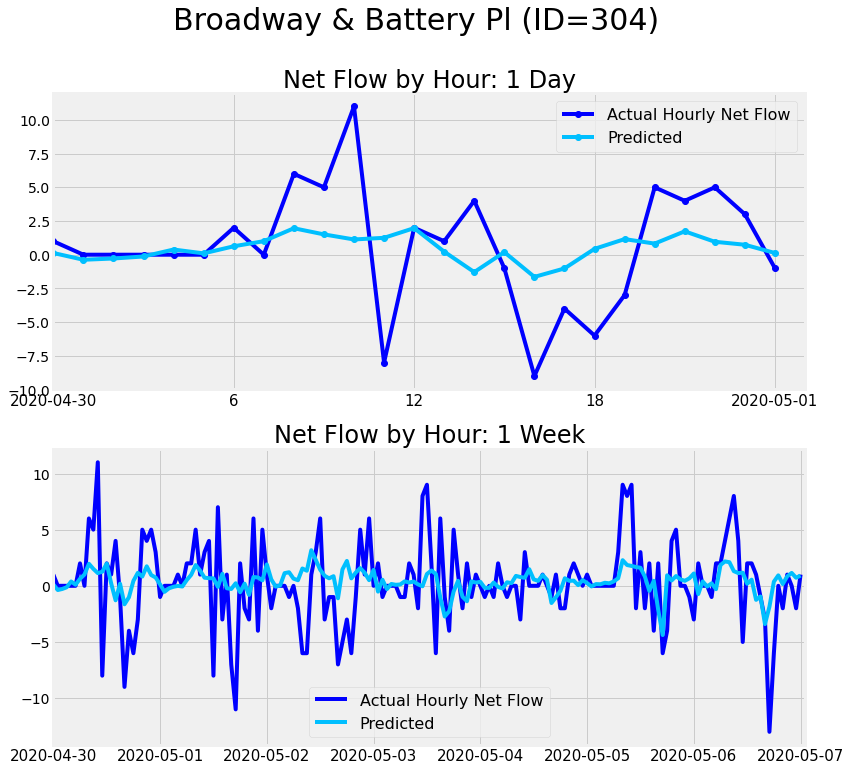

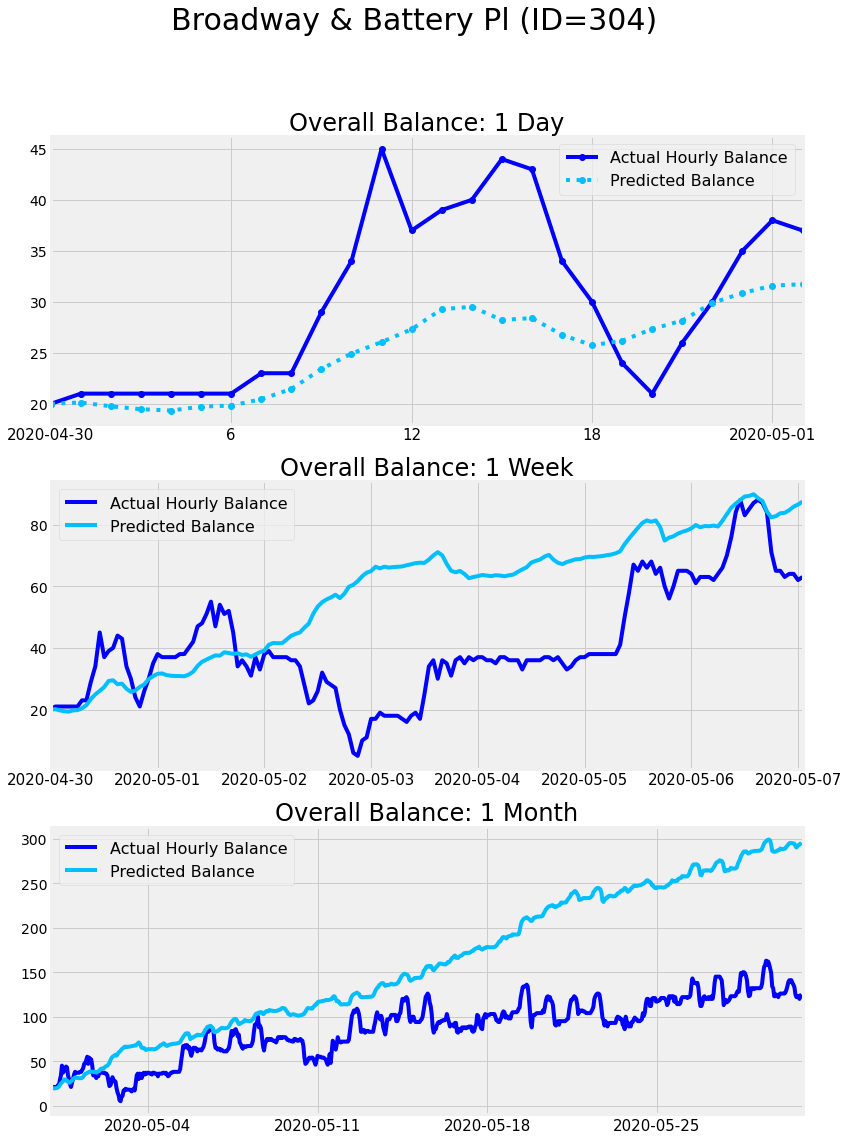

Finished Training for Station ID: 304


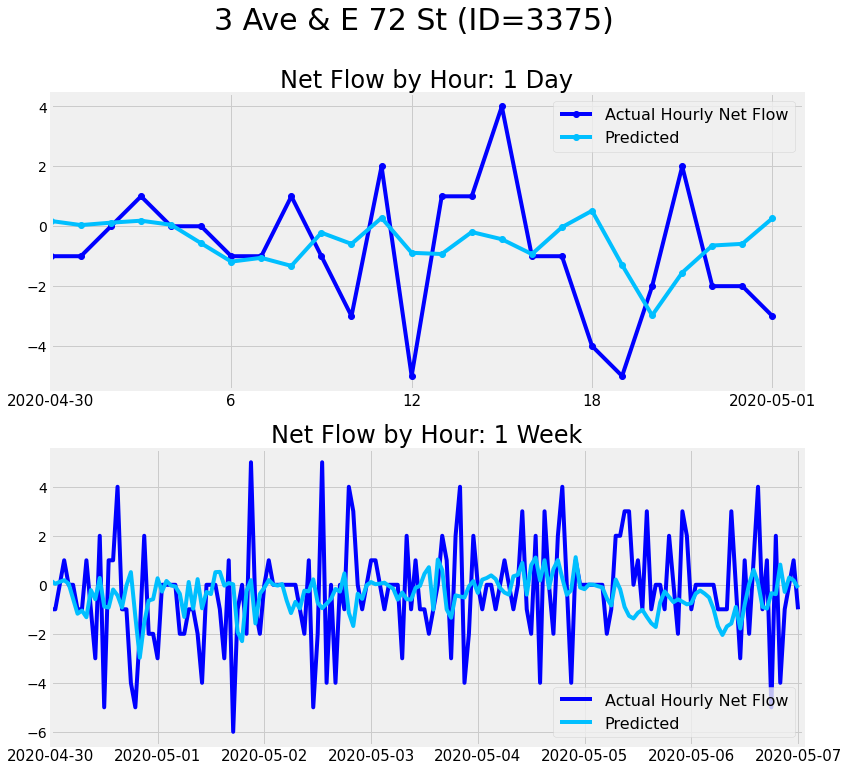

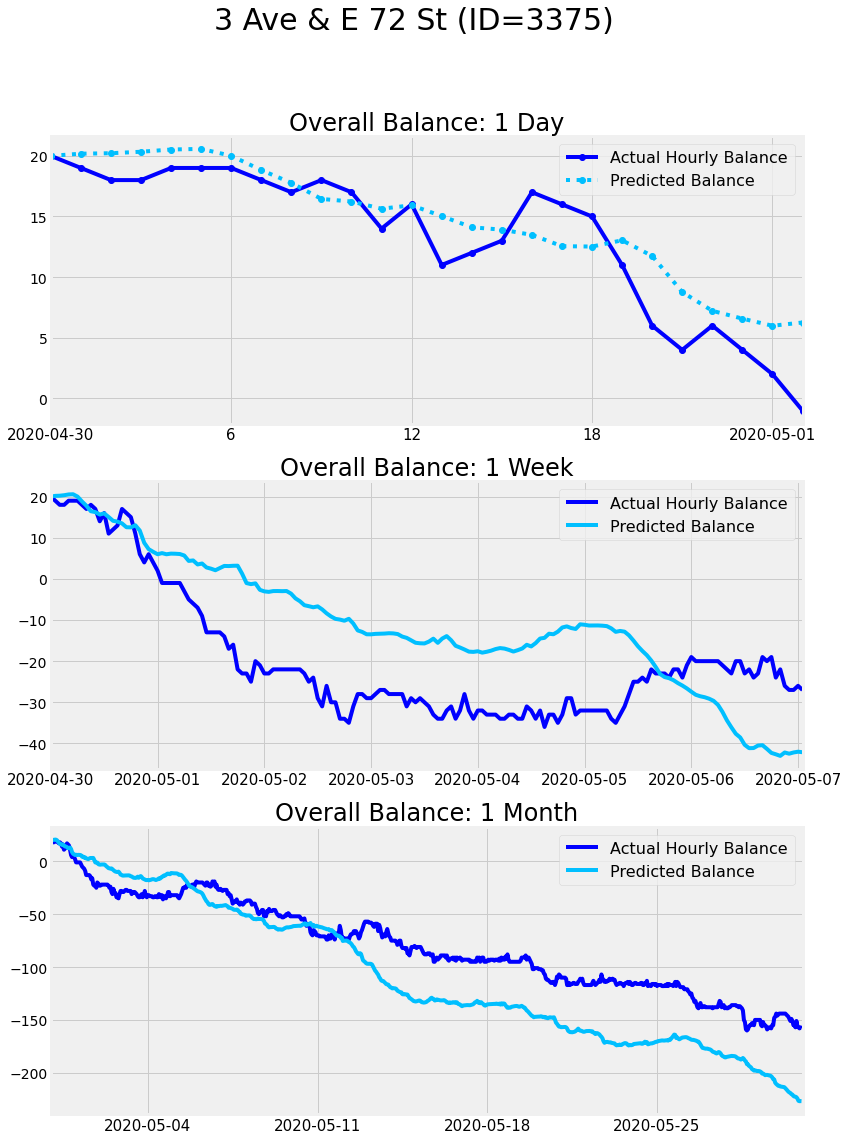

Finished Training for Station ID: 3375


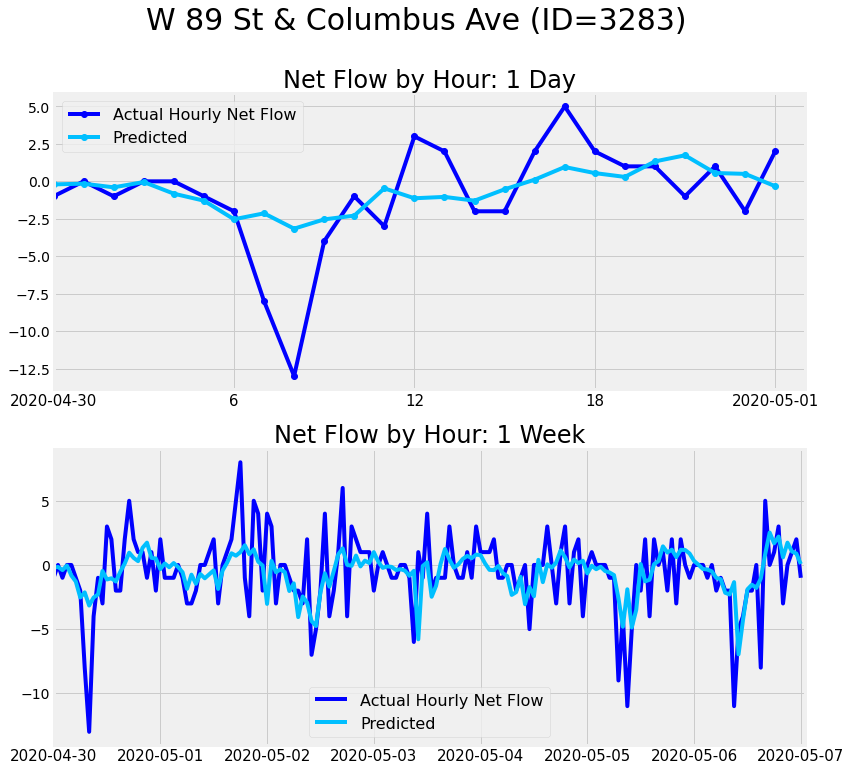

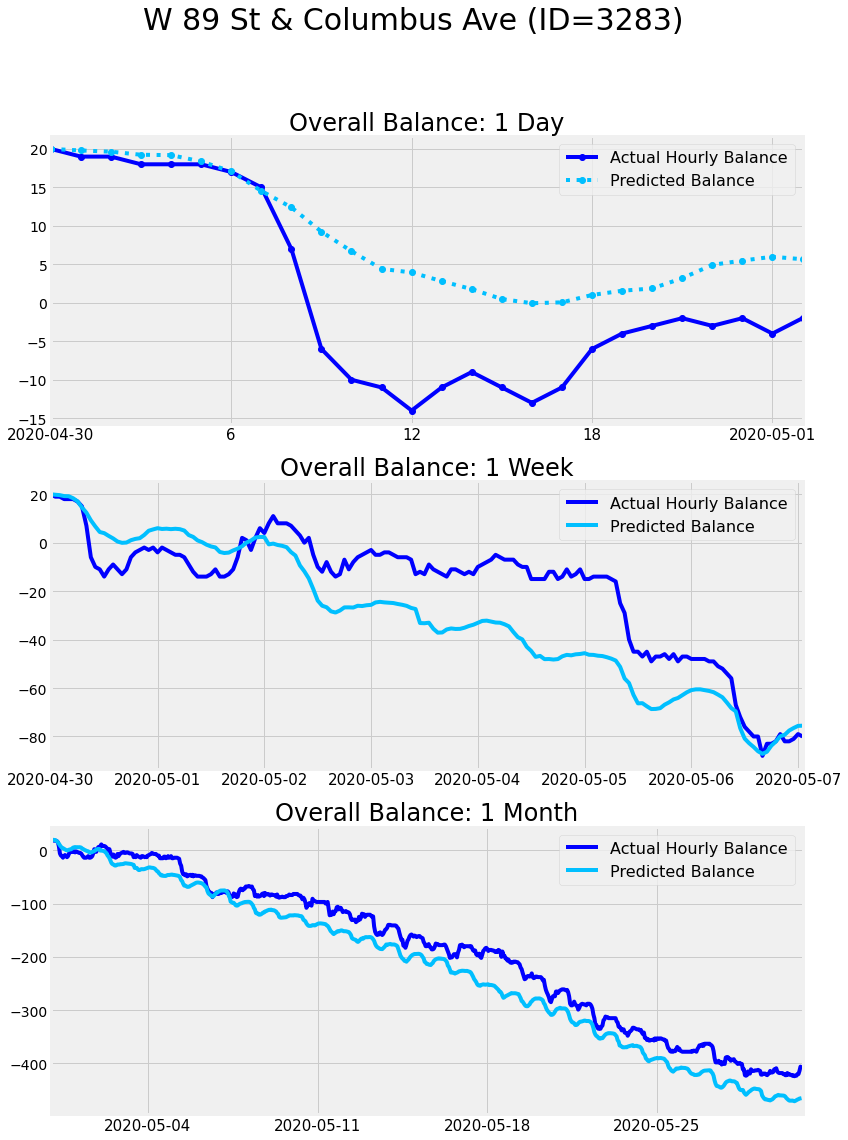

Finished Training for Station ID: 3283
Time Taken 1629858912.9111414


In [24]:
start = time.time()
# To Stpre Test and Train R^2 Results
TestR2s = []
TrainR2s = []

# Store names of the Stations
names = []

# dict of sublists -- each sublist contains the predicted balances per station
PREDS = {} 

BALANCES = {}
EXPECTED_BALANCES = {}

# Hours after which July 2020 Data starts (in our Dataset)
cutoff = 5112
# Fisrt Full Entry witihout any Nulls 
start = 168

for ID in IDs_smaller:
    bike, name = correctDateTime(BIKE)
    names.append(name)
    # ------------------------------ PREPROCESSING OF DATASET -----------------------------
    # Create departure and arrival pivot tables
    
    monthDep = HourlyCount(bike)
    monthArv = HourlyCount(bike, False)

    ### Merge departure and arrival tables, and create net table
    StationActivity = MergeTables(monthDep, monthArv, multiple=True, cols=['dep__', 'arv__'])
    StationActivity = StationActivity[StationActivity['id']==ID]
    
    
    StationActivity = BreakTimeColumn(StationActivity, dates)
    
    # NETS is the net flow of bikes on a stand
    # DEPS shows number of bikes leaving the stand
    # ARRVS shows number of bikes arriving at the stand
    nets2 = PreprocessData(StationActivity, ID, "net")
    deps2 = PreprocessData(StationActivity, ID, "dep")
    arvs2 = PreprocessData(StationActivity, ID, "arv")
    
    date_col = ["date", "weekday", "month", "hour"]
    merged = MergeTables(deps2, arvs2, multiple=False, cols=date_col)
    total = MergeTables(nets2, merged, multiple=False, cols=date_col)
    total = MergeTables(total, weather, multiple=False, cols=["date", "hour"])
    total = total.sort_values(by=['date', 'hour']).reset_index(drop=True)
    
    #------------------------- Introduce autoregressive features---------------------------
    total = introduceAutoregrression(total, ["nets", "deps"])                

    # Split Train and Test Data as well as remove month of March
    TrainX, TestX, TrainY, TestY, DF, X, y = TrainTestSplit(total, dates)

    # -------------------------------------- Modeling --------------------------------------
    preds, RF, TestResults, TrainResults = Modeling(TrainX, TestX, TrainY, TestY)
    #Keep track of results:
    TestR2s.append(TestResults)
    TrainR2s.append(TrainResults)

    # ----------------------------------- VISUALIZATION ------------------------------------
    label_locations = np.arange(0, len(X), 24)
    date_labels = [dates[x] for x in (label_locations/24).astype(int)]
    w_label_locations = np.arange(0, len(X), 168)
    w_date_labels = [dates[x] for x in (w_label_locations/24).astype(int)]
    starting_balance = 20 #by default
    
    hour_locations = np.arange(0, len(X), 6)
    hour_labels = [x % 24 for x in hour_locations]
    Dlabels = date_labels.copy()
    for z in range(len(hour_labels)):
        if z % 4 == 0:
            entry = int(z/4)
            hour_labels[z] = date_labels[entry]
    
    # NET FLOW PLOTS
    plt.figure(figsize=[12, 12])
    plt.suptitle(name+' (ID='+str(ID)+')', size=30)

    # ONE DAY
    # Predicting Net Flow per Hour
    plt.subplot(211)
    plt.plot(y[cutoff:cutoff+25], marker='o', color='blue')
    plt.plot(pd.Series(preds[:25], index=np.arange(cutoff, cutoff+25, 1)), color='deepskyblue',
        marker='o')
    plt.xticks(hour_locations, hour_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, cutoff+25))
    plt.legend(['Actual Hourly Net Flow', 'Predicted'], fontsize=16)
    plt.title('Net Flow by Hour: 1 Day', size=24)

    # ONE WEEK
    plt.subplot(212)
    plt.plot(y[cutoff:cutoff+169], color='blue')
    plt.plot(pd.Series(preds[:169], index=np.arange(cutoff, cutoff+169, 1)), color='deepskyblue')
    plt.xticks(label_locations, date_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, cutoff+169))
    plt.legend(['Actual Hourly Net Flow', 'Predicted'], fontsize=16)
    plt.title('Net Flow by Hour: 1 Week', size=24)

    plt.savefig(name+' ('+str(ID)+') Net Flows.pdf')

    #BALANCE PLOTS
    # early_hours is midnight to noon on 31/7
    early_hours = pd.Series(0, index=[cutoff-1]).append(np.cumsum(TestY.head(12))) 
    early_hours = early_hours + starting_balance
    real_start_balance = np.array(early_hours)[-1]

    cumulative_actuals = np.cumsum(TestY.loc[cutoff+12:]) + real_start_balance
    total_actual = pd.concat([early_hours, cumulative_actuals])
    total_actual = total_actual.shift(periods=1)

    cumulative_preds = pd.Series(np.cumsum(preds),index=np.arange(cutoff, cutoff+len(preds)))
    cumulative_preds = pd.Series(0, index=[cutoff-1]).append(cumulative_preds)
    cumulative_preds = cumulative_preds + starting_balance
    cumulative_preds = cumulative_preds.shift(periods=1)
    
    # Plots
    plt.figure(figsize=[12, 18])
    plt.suptitle(name+' (ID='+str(ID)+')', size=30)

    # Daily Map
    plt.subplot(311)
    plt.plot(total_actual.loc[cutoff:cutoff+25], marker='o', color='blue')
    plt.plot(cumulative_preds.loc[cutoff:cutoff+25], marker = 'o', color = 'deepskyblue', linestyle=':')
    plt.xticks(hour_locations, hour_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, cutoff+25))
    plt.legend(['Actual Hourly Balance', 'Predicted Balance'], fontsize=16)
    plt.title('Overall Balance: 1 Day', size=24)

    # Weekly Map
    plt.subplot(312)
    plt.plot(total_actual.loc[cutoff:cutoff+169], color='blue')
    plt.plot(cumulative_preds.loc[cutoff:cutoff+169], color = 'deepskyblue')
    plt.xticks(label_locations, date_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, cutoff+169))
    plt.legend(['Actual Hourly Balance', 'Predicted Balance'], fontsize=16)
    plt.title('Overall Balance: 1 Week', size=24)

    # Monthly Map
    plt.subplot(313)
    plt.plot(total_actual, color='blue')
    plt.plot(cumulative_preds, color = 'deepskyblue')
    plt.xticks(w_label_locations, w_date_labels, size=15)
    plt.yticks(size=14)
    plt.xlim((cutoff, len(y+1)))
    plt.legend(['Actual Hourly Balance', 'Predicted Balance'], fontsize=16)
    plt.title('Overall Balance: 1 Month', size=24)
    
    plt.savefig(name+' ('+str(ID)+') Balances.pdf')
    plt.show()
    ##JSON FILES
    P = preds[1:24]
    P = [int(round(p)) for p in P]
    PREDS[ID] = P
    
    balances = np.append(0, np.cumsum(TestY.loc[cutoff+1:cutoff+23]))+20
    balances = [int(b) for b in balances]
    BALANCES[ID] = balances
    
    ExpectedBalance_1Hour = [balances[y]+P[y] for y in range(len(P))]
    E = [int(x) for x in ExpectedBalance_1Hour]
    EXPECTED_BALANCES[ID] = E
    
    print(f"Finished Training for Station ID: {ID}")
end = time.time()
print(f"Time Taken {end-start}")

### RESULT
Save Predictions, Balance, and Expected Balance to json

In [26]:
import json
with open('PREDS.json', 'w') as outfile:  
    json.dump(PREDS, outfile)
with open('BALANCES.json', 'w') as outfile:  
    json.dump(BALANCES, outfile)
with open('EXPECTED_BALANCES.json', 'w') as outfile:  
    json.dump(EXPECTED_BALANCES, outfile)

Other graphs can be found in the NefFlows and Balances folders

We achieved far greater test set accuracy for some stations (e.g. those with predictable patterns) than others.

Text(0.5, 1.0, 'Predicted Balance: 1 Hour in Advance')

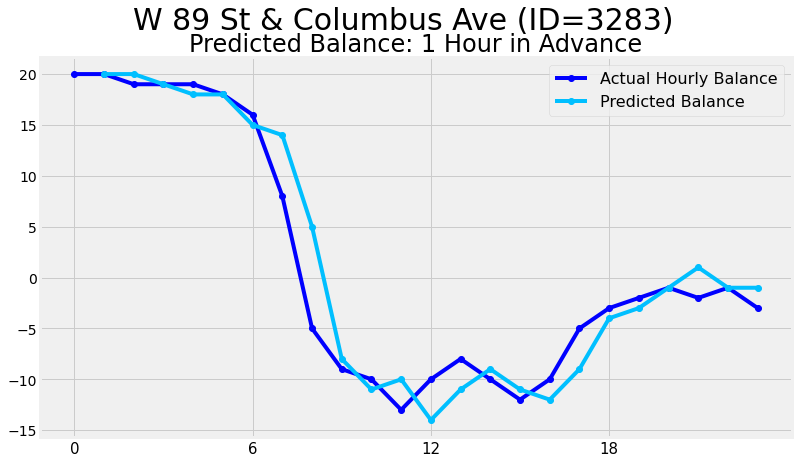

In [27]:
E = np.append(ExpectedBalance_1Hour, 56)
PP = np.append(P, 0)
plot_chart = pd.DataFrame(np.vstack((balances, PP, E))).T
plot_chart = plot_chart.rename(columns={0: 'Current Balance', 
                                        1: 'Predicted Change in\n Next Hour',
                                       2: 'Predicted Balance in Next Hour'})


plt.figure(figsize=[12, 7])
plt.suptitle(name+' (ID='+str(ID)+')\n', size=30)

plt.subplot(111)
plt.plot(plot_chart['Current Balance'], marker='o', color='blue')
plt.plot(np.arange(1, 24), ExpectedBalance_1Hour, marker = 'o', 
         color = 'deepskyblue')
plt.xticks(np.arange(0, 24, 6), size=15)
plt.yticks(size=14)
plt.legend(['Actual Hourly Balance', 'Predicted Balance'], fontsize=16)
plt.title('Predicted Balance: 1 Hour in Advance', size=24)

In [28]:
plot_chart

,Current Balance,Predicted Change in\n Next Hour,Predicted Balance in Next Hour
0,20,0,20
1,20,0,20
2,19,0,19
3,19,-1,18
4,19,-1,18
5,18,-3,15
6,16,-2,14
7,8,-3,5
8,-5,-3,-8
9,-9,-2,-11


Forecast Results for every station

In [29]:
ForecastResults = pd.DataFrame(np.vstack((IDs_smaller, names, TestR2s, TrainR2s))).T
ForecastResults = ForecastResults.rename(columns={0:'StationID', 1: 'Name',
                                                 2:'Test R^2', 3:'Train R^2'})
ForecastResults

,StationID,Name,Test R^2,Train R^2
0,519,Pershing Square North,0.317,0.746
1,392,Jay St & Tech Pl,-0.02,0.632
2,426,West St & Chambers St,0.069,0.82
3,497,E 17 St & Broadway,0.352,0.802
4,3164,Columbus Ave & W 72 St,0.139,0.744
5,281,Grand Army Plaza & Central Park S,0.227,0.914
6,3443,W 52 St & 6 Ave,0.665,0.929
7,304,Broadway & Battery Pl,0.195,0.908
8,3375,3 Ave & E 72 St,-0.044,0.599
9,3283,W 89 St & Columbus Ave,0.188,0.668



### Feature Importances -- for ID=519 (Pershing Square North, Grand Central)
Features:

- **"hour_average_nets_past_week":** the average net flow for that hour across the seven previous days. (For example, if we're predicting net flow for 9/27/2017 at 9AM, we'll compute the average net flow at 9AM from 9/20-9/26).
- **"hour_average_neets_weekday_past3":** the average net flow for that hour across the three previous weekdays. (For example, if we're predicting net flow for Wednesday, 9/27/2017 at 9AM, we'll compute the average net flow at 9AM from the previous three Wednesdays: 9/6, 9/13, and 9/20).
- **"nets_12h":** cumulative net flow at station in past 12 hours.
- **"nets_24h":** cumulative net flow at station in past 24 hours.
- **"nets t-1":** net flow at station in previous hour
- **"nets t-2":** net flow at station in second-most previous hour

Similar features are in place for number of departures (not arrivals). The "departure" variables may seem redundant, but they generally seemed to improve test set performance, so I kept them in the model.

In [30]:
Ftable = pd.DataFrame(np.vstack((X.columns.values, RF.feature_importances_))).T. \
                        sort_values(by=1, ascending=False)
    
Ftable = Ftable.reset_index(drop=True).rename(columns={0: 'Feature Name', 1:'Gini Coeff.'})
Ftable

,Feature Name,Gini Coeff.
0,hour_average_nets_past_week,0.149681
1,nets t-1,0.0987923
2,hour,0.0820759
3,hour_average_nets_weekday_past3,0.0620629
4,deps t-1,0.0512636
5,nets_12h,0.0512397
6,nets_24h,0.0490157
7,hour_average_deps_past_week,0.0465969
8,pres,0.0456881
9,hour_average_deps_weekday_past3,0.0447549


## Design and Results

### Setup

### Environment: 

The following results were generated using a simulation with linearly increasing bike stock. The initial stock at 00:00 is 20 and 3 additional bikes were added hourly. There would be 89 bikes at 23:00 if no bikes were removed during the day.

### Agent: 

The agent can only remove bikes from a station in a quantity of 0, -1, -3, or -10 in each hour.

### Reward / Penalty:

- +10 if the bike stock is equal or less than 50 at hour 23:00

- -10 if the bike stock is more than 50 at any given hour

- -0.1 * number of bike removed at each hour

- -20 if bike stock becomes negative at any given hour



Continued in the Test Script..